In [80]:
# using Pkg
# Pkg.activate("")

# # Packages that you need
# packages_to_install = ["MLDatasets", "Plots", "Statistics", "Distributions", "Random", "Flux", "Yao", "FLOYao", "PythonCall", "BenchmarkTools", "Dates", "FiniteDifferences"]

# for pkg in packages_to_install
#     Pkg.add(pkg)
# end

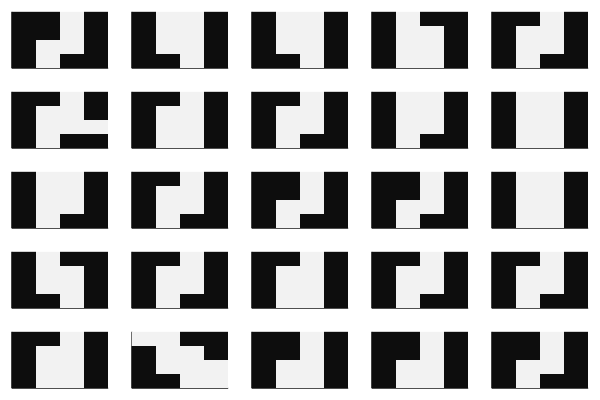

In [81]:
using MLDatasets
using Plots
using Statistics
using Distributions
using Random

train = 25 # Size of training dataset

digit = 1 # Digit to be learned
image_size = 28 # Size of image
compress_size = 4 # Size of compressed image

function compress(img, original, compress, max = true) #If max is false, then it does mean-convolution instead
    ratio = original ÷ compress
    compressed = zeros(compress, compress)
    a = []
    for i in 0:compress-1
        for j in 0:compress-1
            empty!(a)
            for p in 1:ratio
                for q in 1:ratio
                    push!(a, img[(ratio*i) + p, (ratio*j) + q])
                end
            end
            compressed[i+1, j+1] = max ? maximum(a) : mean(a)
        end
    end
    return compressed
end

train_set = MNIST(:train)
train_labels = MNIST(split=:train).targets

data_train = []
c = 1
trainstats = []
for _ in 1:train
    while train_labels[c] != digit
        c += 1
    end
    push!(data_train, compress(rotl90(train_set[c][1]), image_size, compress_size) .> 0.5)
    push!(trainstats, sum(compress(train_set[c][1], image_size, compress_size) .> 0.5))
    c += 1
end

plot([heatmap(x, color=:grays, colorbar = false, ticks = false) for x in data_train]...) #Is there any way to make this look nicer? use pythoncall and matplotlib i guess

In [82]:
using Yao
using Flux

N = compress_size^2 #Number of qubits

function NeuralNetwork(num_dim = N, random = true)
    net = Chain(Dense(num_dim, 25, relu), Dense(25, 1, identity))
    if !random
        for p in Flux.params(net)
            p .= (ones(size(p)) .* 0.08)
        end
    end
    return net
end

#d = NeuralNetwork() #Parameters are random (typically is N(0, sqrt(width)), not really sure how it's implemented)
d = Chain(Dense(N, 10, relu), Dense(10, 1, sigmoid)) #I have no clue what this looks like, and why does it have more parameters than expected (bias?)

nparams = sum(length, Flux.params(d))
println("Number of parameters in discriminator: $nparams")

layers = 5
g = chain(N) #Making the generator, which is a matchgate ansatz (IS IT???) yes because it's made up of nn XX gates and single-qubit Z gates
for _ in 1:layers
    for i in 1:N-1
        push!(g, rot(kron(N, i => X, i+1 => X), 0.))
    end
    for i in 1:N
        push!(g, put(N, i => Rz(0.)))
    end
end

# function build_circuit(n::Int = N, nlayers::Int = layers)
#     circuit = chain(n) #Making the generator, which is a matchgate ansatz; this just uses Yao though? or does saying "using FLOYao" somehow change the implementation... Not really sure
#     for _ in 1:nlayers
#         for i in 1:N-1
#             push!(circuit, rot(kron(N, i => X, i+1 => X), 0.))
#         end
#         for i in 1:N
#             push!(circuit, put(N, i => Rz(0.)))
#         end
#     end
# end

#g = build_circuit()
#g = build_circuit() |> autodiff(:QC)

nparams = nparameters(g)
println("Number of parameters in generator: $nparams")  
#dispatch!(g, ones(nparams) ./ 100); 
dispatch!(g, :random);

Number of parameters in discriminator: 181
Number of parameters in generator: 155


μ: 6.48
σ: 1.004987562112089
Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

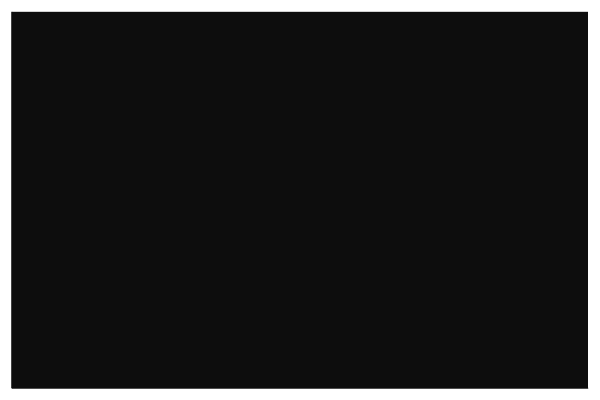

In [83]:
using FLOYao
using Random
using Distributions

#Not sure if there is a better pprior that we can choose, sometimes u get a lot of white or black bc variance is high (resolution: change var from sigma to sigma/10)
mu = mean(trainstats)
sigma = std(trainstats)
println("μ: $mu")
println("σ: $sigma")
#dist = Normal(mu, sigma/20)
dist = Normal(mu, 1)

#ratio = rand(dist) / N
ratio = 0
function pprior() #For each square, probability ratio that it's white, where ratio ~ N(mean(data), std(data)) /  N; maybe we can vary pprior later?
    a = rand(N) .< ratio
    return FLOYao.product_state(Int.(a)) #Returns MajoranaReg; Prepares it to be sent through the generator 
end

pprior_example = rand(N) .< ratio
print(pprior_example)
heatmap(rotl90(reshape(pprior_example, compress_size, compress_size)) .> 0.5, color=:grays, colorbar = false, ticks = false)

In [84]:
using Flux: train!
using Yao
using FLOYao

batch_size = train #Are you supposed to randomly pick batch_size data points at random each time if train is big? idk
#This is the 

#g takes as input x = Int.(pprior()); FLOYao.product_state(x)
#d takes as input measure(x |> g)

function convertgd(g_output::Vector) #turns the output of reg |> g |> measure into an Int vector
    result = []
    for i in 1:N 
        push!(result, g_output[1][end - i + 1])
    end
    Int.(result)
end

function run_circuit(z::MajoranaReg) #z is a MajoranaReg drawn from pprior (to guarantee matchgate speedup); this function applies D(G(z))
    g_output = z |> g |> measure
    d_input = convertgd(g_output)
    d_output = d_input |> d
    d_output |> first
end

t = time()
measurement = run_circuit(pprior())
println("runcircuit: $measurement")
println(time() - t)

function run_d(x::BitMatrix) #this function applies D(x), where x is an element of data_train 
    d_output = x |> vec |> d
    d_output |> first
end

function gLoss(z::MajoranaReg) #z is sampled from pprior(); gLoss is technically a function of params(g) but this is implicitly implemented in run_circuit
    -log(run_circuit(z))
    #log(1 - run_circuit(z))
end

#This is the BCE loss?
function dLoss(m, real, fake) #m is the discriminator, real is the actual data, fake is G(z) where z is sampled from pprior()
    -(log.(m(real)) + log.(1 .- m(fake))) |> first
end


# function dLoss(m, real, fake) #BCE loss

# end

# function dLoss(m, fake)
#     -(log.(m(real)) + log.(1 .- m(fake))) |> first
# end

z = pprior()
print(gLoss(z))

runcircuit: 0.32884246
0.054171085357666016
0.8202229

In [85]:
using Yao
using FLOYao

# Worry about this another day
# function gradient(op, reg::MajoranaReg) #does expect' (from FLOYao? or does it come from Yao?) use AD? Also idk what op should be
#     _, params_grad = expect'(op, reg => g)
# end

samplemean_batchsize = 100 #What is a good samplemean_batchsize? maybe just pick one that doesn't take a super long time 

function parametershift_grad(b = samplemean_batchsize)
    temp_params = parameters(g)
    grad = zeros(nparameters(g))
    for i in 1:nparameters(g)
        plus = 0
        minus = 0
        temp = parameters(g)[i]
        temp_params[i] = temp + π/2
        dispatch!(g, temp_params)
        for _ in 1:b
            z = pprior()
            plus += gLoss(z)
        end
        plus /= b
        temp_params[i] = temp - π/2
        dispatch!(g, temp_params)
        for _ in 1:b
            z = pprior()
            minus += gLoss(z)
        end
        minus /= b
        grad[i] = (minus - plus) / 2
        temp_params[i] = temp
        dispatch!(g, temp_params)
    end
    grad
end

#parametershift_grad is O((samplemean_batchsize) * (nparameters))
#In computing sample means, I used different samples from pprior(); might program something later in which we use the same samples z in estimating both sample means...

for _ in 1:5
    print(parametershift_grad()) #Should print similar numbers...
end

[0.04184311628341675, -0.05214264988899231, -0.06314417719841003, 0.03401458263397217, -0.03943556547164917, -0.04315641522407532, -0.013821065425872803, 0.059989720582962036, 0.018573105335235596, -0.018634438514709473, 0.005725085735321045, -0.006740987300872803, -0.021857023239135742, 0.010566294193267822, -0.04418095946311951, 0.01119619607925415, 0.04264184832572937, 0.055039554834365845, 0.04859223961830139, 0.00731128454208374, 0.021180689334869385, 0.010646075010299683, -0.014644891023635864, -0.010188937187194824, -0.0023802518844604492, 0.02022939920425415, -0.009497284889221191, -0.01185557246208191, 0.007708609104156494, -0.013391554355621338, 0.015220999717712402, -0.039412349462509155, -0.06723582744598389, -0.061658233404159546, 0.0029027462005615234, -0.0026051998138427734, 0.006880581378936768, -0.010787129402160645, 0.01657775044441223, -0.041180044412612915, -0.046236395835876465, -0.02935105562210083, -0.012834668159484863, -0.054586589336395264, 0.03949457406997681

[-0.02869570255279541, -0.05805087089538574, -0.04474020004272461, -0.009253859519958496, -0.0551571249961853, -0.026694178581237793, -0.022322118282318115, 0.005403637886047363, -0.01459205150604248, -0.023380368947982788, -0.017841100692749023, 0.008222699165344238, -0.022107839584350586, 0.03227555751800537, -0.05575266480445862, 0.021579325199127197, 0.03669649362564087, 0.021293342113494873, -0.0037099719047546387, -0.0030310750007629395, 0.029777169227600098, -0.004780471324920654, 0.021935701370239258, 0.019142866134643555, 0.009269893169403076, 0.0025327205657958984, 0.009451627731323242, -0.0004570484161376953, 0.027946144342422485, 0.02270430326461792, 0.0011401176452636719, -0.0183640718460083, -0.046107709407806396, -0.04987680912017822, 0.033214032649993896, -0.0020200014114379883, -0.043914794921875, -0.012845456600189209, -0.004288315773010254, 0.006760299205780029, -0.00919109582901001, -0.0113677978515625, 0.020467609167099, -0.03832605481147766, 0.044553399085998535, 

[0.021512389183044434, -0.053085923194885254, -0.059616655111312866, 0.0392337441444397, -0.020076632499694824, -0.04933524131774902, -0.0212365984916687, 0.050585389137268066, 0.0461658239364624, -0.00956958532333374, 0.010954737663269043, 0.000841677188873291, -0.030972391366958618, 0.02766597270965576, -0.029173046350479126, -0.008153378963470459, 0.0354858934879303, 0.040590882301330566, 0.018590211868286133, -0.0073969364166259766, 0.033637046813964844, -0.00012636184692382812, 0.026651501655578613, 0.03013443946838379, 0.0076506733894348145, 0.009817957878112793, 0.003043234348297119, 0.009599030017852783, 0.01309657096862793, -0.001457512378692627, -0.0067903101444244385, 0.03669184446334839, -0.0623302161693573, -0.057605594396591187, -0.013090789318084717, 0.002377331256866455, -0.0005002021789550781, -0.0120411217212677, 0.00855928659439087, -0.01460084319114685, -0.029943346977233887, -0.010908156633377075, 0.02507510781288147, -0.035704106092453, 0.05612868070602417, 0.0135

[0.02198803424835205, -0.04600444436073303, -0.05383658409118652, 0.0059119462966918945, -0.04703211784362793, 0.004114508628845215, -0.01949530839920044, 0.06327468156814575, -0.00483432412147522, -0.02237778902053833, -0.03428646922111511, 0.006202876567840576, -0.034280240535736084, 0.033496588468551636, -0.050699710845947266, -0.0176084041595459, 0.04434669017791748, 0.06516513228416443, 0.020029425621032715, 0.013040244579315186, 0.02693694829940796, 0.011932611465454102, 0.012053489685058594, -0.008000433444976807, -0.03032815456390381, -0.017854958772659302, 0.038126587867736816, 0.0034499764442443848, -0.020271241664886475, -0.009191751480102539, -0.006881594657897949, 0.0025649666786193848, -0.04894706606864929, -0.04729163646697998, 0.00019669532775878906, -0.020923733711242676, -0.033601611852645874, -0.015861809253692627, -0.0005863308906555176, -0.01498955488204956, 0.013210773468017578, 0.01903456449508667, -0.04458802938461304, -0.05480274558067322, 0.02049398422241211, 

[0.03893911838531494, -0.026496797800064087, -0.04236069321632385, 0.04970186948776245, -0.05578821897506714, -0.023473262786865234, -0.029666543006896973, 0.03367048501968384, 0.003167092800140381, 0.021736204624176025, 0.010987699031829834, 0.017890483140945435, -0.0591091513633728, 0.018354088068008423, -0.042252302169799805, -0.01795792579650879, 0.03071194887161255, 0.018086344003677368, 0.021310120820999146, -0.000815272331237793, 0.015686392784118652, -0.020674049854278564, 0.01815098524093628, -0.007244288921356201, 0.017572671175003052, 0.028947949409484863, -0.009296059608459473, 0.0076340436935424805, 0.013885170221328735, -0.01946660876274109, -0.005936384201049805, 0.022862136363983154, -0.038059890270233154, -0.030864030122756958, 0.03006291389465332, -0.0008429288864135742, -0.029799193143844604, -0.01948946714401245, 0.025435030460357666, 0.0038138628005981445, -0.023474186658859253, 0.01829308271408081, 0.016110241413116455, 0.0016144514083862305, 0.0070037841796875, -

In [86]:
g_lr = 1
d_lr = 0.5

opt_flag = 1
if opt_flag == 1
    d_opt = Flux.setup(Adam(), d) 
elseif opt_flag == 2
    d_opt = Flux.setup(Descent(d_lr), d) #lol is this right
elseif opt_flag == 3
    d_opt = Flux.setup(SGD(), d) #yeah idk anymore
end

gLoss_values = []
dLoss_values = []
g_epochs = 10
d_epochs = 3
epochs = 10

fake_samples = []
for m in 1:batch_size
    z = pprior()
    push!(fake_samples, z)
end

# for j in 1:1
#     s = 0
#     grads = []
#     for m in 1:batch_size
#         z = fake_samples[m]
#         push!(grads, finitediff_grad(z, ε))
#         s += gLoss(z)
#     end
#     dispatch!(-, g, mean(grads) * g_lr)
#     #println("Generator loss for g_epoch $j:", s / batch_size)
#     push!(gLoss_values, s / batch_size)
# end

for i in 1:epochs
    t = time()
    for j in 1:g_epochs
        tg = time()
        s = 0
        grads = parametershift_grad()
        # for m in 1:batch_size
        #     #z = fake_samples[m]
        #     #s += gLoss(z)
        # end
        # if norm(mean(grads)) > 100
        #     break outerloop
        dispatch!(-, g, grads .* g_lr)
        for m in 1:batch_size
            z = fake_samples[m]
            s += gLoss(z)
        end
        push!(gLoss_values, s / batch_size)
        #println("generator iteration $j done in: ", time() - tg)
    end
    for j in 1:d_epochs
        td = time()
        real = []
        fake = []
        for m in 1:batch_size
            x = data_train[m] |> vec 
            push!(real, Int.(x))
            z = pprior()
            push!(fake, convertgd(z |> g |> measure))
        end
        data = collect(zip(real, fake)) 
        Flux.train!(dLoss, d, data, d_opt)
        s = 0
        for x in data
            s += dLoss(d, x[1], x[2])        
        end
        push!(dLoss_values, s / batch_size)
        #println("discriminator iteration $j done in: ", time() - td)
    end
    println("iteration $i done in: ", time() - t)
end

# for j in 1:500
#     s = 0
#     grads = []
#     for m in 1:batch_size
#         z = fake_samples[m]
#         push!(grads, finitediff_grad(z, ε))
#         s += gLoss(z)
#     end
#     dispatch!(-, g, mean(grads) * g_lr)
#     #println("Generator loss for g_epoch $j:", s / batch_size)
#     push!(gLoss_values, s / batch_size)
# end

iteration 1 done in: 33.50282883644104
iteration 2 done in: 

34.11122012138367


iteration 3 done in: 33.58371710777283
iteration 4 done in: 

33.78321695327759


iteration 5 done in: 33.89866900444031
iteration 6 done in: 

34.11042094230652


iteration 7 done in: 33.96842694282532
iteration 8 done in: 

33.85957407951355


iteration 9 done in: 33.94247102737427
iteration 10 done in: 

33.913405895233154


Generator loss


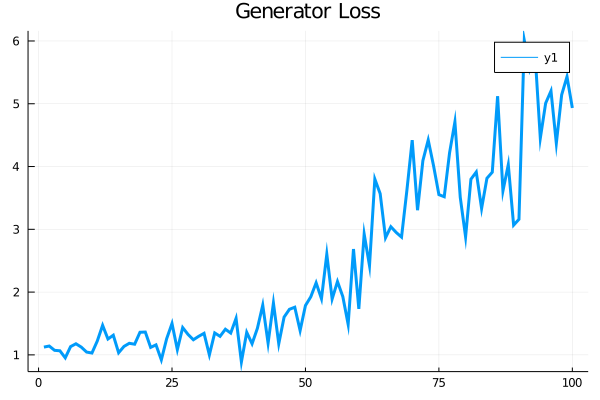

In [87]:
println("Generator loss")

# for l in gLoss_values
#     println(l)
# end

plot(gLoss_values, title = "Generator Loss", linewidth=3)

Discriminator loss


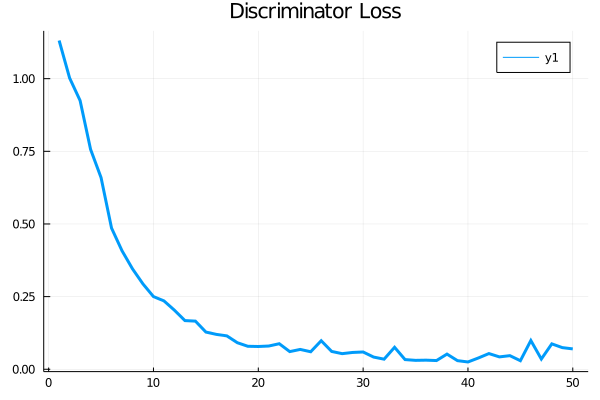

In [88]:
println("Discriminator loss")

# for l in dLoss_values
#     println(l)
# end

plot(dLoss_values, title = "Discriminator Loss", linewidth=3)

In [89]:
#Testing the Discriminator

d_fake = run_circuit(pprior())
println("fake data: $d_fake") #Should print a number close to 0

index = rand(1:train)
d_real = run_d(data_train[index])
println("real data: $d_real") #Should print a number close to 1

fake data: 4.107388e-7
real data: 0.96892804


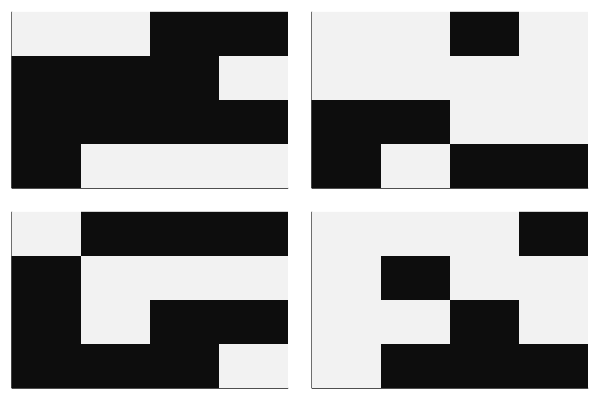

In [90]:
#Testing the Generator

nsamples = 4
samples = []
for i in 1:nsamples
    reg = fake_samples[i]
    s = reg |> g |> measure
    push!(samples, convertgd(s))
end
plot([heatmap(rotl90(reshape(s, compress_size, compress_size)), color=:grays, colorbar = false, ticks = false) for s in samples]...) #Not sure if the reshaping is correct but whatever